<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*VQE algorithm: Application to quantum chemistry*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the IBM Q Experience (QX), consult the [Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Antonio Mezzacapo, Jay Gambetta

### Introduction

One of the earliest and most compelling applications of quantum computation is the idea of using quantum computers to simulate other quantum systems. Quantum simulation of quantum systems encompasses a range of tasks, including most significantly 
    
1. simulation of the time evolution of quantum systems
2. computation of thermal or ground state properties. 

These application are especially useful when considering systems of interacting fermions, such as molecules and strongly correlated materials. The focus of this notebook is on molecular systems, considered to be the ideal bench test for early-stage quantum computers. These states encode a lot of the information about the physical system of interest, and are highly relevant for understanding the properties of materials and complex molecules. The ground state is the starting point for mapping out the phase diagram of condensed matter Hamiltonians and encodes the central information of electronic structure problems in quantum Chemistry. The problem asks the following:

For some physical Hamiltonian *H*, (approximately) prepare the eigenstate $|\psi_G\rangle$, i.e. $H|\psi_G\rangle=E_G|\psi_G\rangle$, where $E_G$ is the smallest eigenvalue of $H$.
    
It is known that in general this problem is intractable even on a quantum computer. This means that we cannot expect an efficient quantum algorithm which prepares the ground state of general local Hamiltonians. Despite this limitation, for a specific Hamiltonian of interest it might be possible to exploit special structure to solve the above problem efficiently. Currently, (at least) four different methods exist to approach this problem. 

1. Quantum phase estimation: Here we assume that we can approximately prepare the state $|\psi_G\rangle$ and then this routine is used to give the eigenvalue. 
2. Adiabatic theorem of quantum mechanics. Here we assume that the system can be moved from an easy prepared ground state adiabtically to the harder state. 
3. Variational quantum eigensolver. Here we assume that ground state can be represented by a prameterization containing a small (e.g., polynomial) number of parameters.
4. Dissipative (non-unitary) quantum operation which has the ground state as a fixed point. Here we assume that we can design this dissiapation map. 

Here we are interested in the third method as this is most likely the simplest to be realized on near term devices. 

The general idea is to define a paremeterization $|\psi(\theta)\rangle$ and minimize the energy 

$$E(\theta) = \langle \psi(\theta)| H |\psi(\theta)\rangle,$$ 

Assumption 1. The set of controls $\theta^*$ that minimizes this objective funtion has a size $|\theta|$ that ploynomial in number of qubits.  

For any Hamiltoian (and shown below) this can be rewritten as a sum over pauli operations  

$$H = \sum_i^M w_i P_i,$$ 

then E(\theta) can be estimated by sampling 

$$E(\theta) = \sum_i^M w_i \langle \psi(\theta)| P_i |\psi(\theta)\rangle,$$ 

Assumption 2. The number of terms to be estimated is polynomial in the number of qubits. In the most general case $M=4^n$ but for physical interesting Hamiltonians like chemisty M = N^4 where N is the number of orbitals.



### Fermionic Hamiltonians

The Hamiltonians describing systems of interacting fermions can be expressed in second quantization language, considering fermionic creation (annihilation) operators $a^\dagger_\alpha(a_\alpha)$, relative to the $\alpha$-th fermionic mode. In the case of molecules, the $\alpha$ labels stand for the different atomic or molecular orbitals. Within the second-quantization framework, a generic molecular Hamiltonian with $M$ orbitals can be written as 
$$H =H_1+H_2=\sum_{\alpha, \beta=0}^{M-1} t_{\alpha \beta} \, a^\dagger_{\alpha} a_{\beta} +\frac{1}{2}  \sum_{\alpha, \beta, \gamma, \delta = 0}^{M-1} u_{\alpha \beta \gamma \delta}\, a^\dagger_{\alpha} a^\dagger_{\gamma} a_{\delta} a_{\beta},$$
with the one-body terms representing the kinetic energy of the electrons and the potential energy that they experience in the presence of the nuclei, 
$$ t_{\alpha\beta}=\int d\boldsymbol x_1\Psi_\alpha(\boldsymbol{x}_1) \left(-\frac{\boldsymbol\nabla_1^2}{2}+\sum_{i} \frac{Z_i}{|\boldsymbol{r}_{1i}|}\right)\Psi_\beta (\boldsymbol{x}_1),$$
and their interactions via Coulomb forces 
$$ u_{\alpha\beta\gamma\delta}=\int\int d \boldsymbol{x}_1 d \boldsymbol{x}_2 \Psi_\alpha^*(\boldsymbol{x}_1)\Psi_\beta(\boldsymbol{x}_1)\frac{1}{|\boldsymbol{r}_{12}|}\Psi_\gamma^*(\boldsymbol{x}_2)\Psi_\delta(\boldsymbol{x}_2),$$
where we have defined the nuclei charges $Z_i$, the nuclei-electron and electron-electron separations $\boldsymbol{r}_{1i}$ and $\boldsymbol{r}_{12}$, the $\alpha$-th orbital wavefunction $\Psi_\alpha(\boldsymbol{x}_1)$, and we have assumed that the spin is conserved in the spin-orbital indices $\alpha,\beta$ and $\alpha,\beta,\gamma,\delta$.

### Molecules considered in this notebook 

We consider in this notebook the optimization of two potential energy surfaces, for the hydrogen and lithium hydride molecules, obtained using the STO-3G basis. The molecular Hamiltonians are computed as a function of their interatomic distance and then mapped to 2 (H$_2$) and 4 (LiH$_2$) qubit problems, via elimination of core and high-energy orbitals and removal of $Z_2$ symmetries [1].

### Approximate Universal Quantum Computing for quantum chemisty problems

Recently there has been interest in investgating approximate algorithims for optimization [ADD REFS]. Here we show a slight variation to them which we have been looking at under the general concept of approximate quantum computing.  In general we dont expect this to have a expodential speed up but due to the nature and importance of these problems it is worth investigating Heuristic approaches on a quantum computer. The hope is that that due to the large space of a quantum computer we can explore the problem by exploiting entanglement to trade expodential calls for quantum depth. 

The Algorithm works as follows:
1. Choose a Ising problem (can have higher powers of Z).
2. Choose the maximum depth of the quantum circuit (this could be done adaptively.
3. Choos a set of controls $\theta$ and make a trial function $|\psi(\theta)\rangle$.
4. Evaluate $C = \langle\psi~|H|~\psi\rangle = \sum_i w_i \langle\psi~|Z_i|~\psi\rangle+ \sum_{i<j} w_{ij} \langle\psi~|Z_iZ_j|~\psi\rangle$ by sampling the outcome of the circuit and adding the expectation values together.
5. Use a classical optimizer to choose a new set of controls.
6. Continue until the C has reach a minimium and return $|\langle z~|\psi\rangle|^2$.
    

Not some benifits on this over making this is real hardware is we are not limited to the connectivity of the device and it is trival to map optimize problems to the virtual Hamiltonain which we make though simulation. Getting higher orders such as $Z_iZ_jZ_k$ is simple which in real hardware is generally possible. The noise is mainly due to the gates and if the depth is small enough we can perform this high fidelity.

It is our belief the difficult of finding good Heuristic algorithms will come down ot the trial funciton. Do we choose a trial function that has entanglement in a way that best aligns with the problem (as indicated in [REF]). or do we make the amount of entanglement a variable [REF]. These questions are beyond our goals here and we will consider only the simplie trial functions 

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a function of cPhase gates (fully entangling), and $U_\mathrm{single}(\theta) = Z(\theta_2)Y(\theta_1)^{\otimes n}$, where $n$ is the number of qubits and $m$ is the depth of the quantum circuit. The motivation for this choice is that for these classical problems this choice allows us to search over the space of states that have only real superpostions and dont have to worry about refocusing out all the complex phases but still can exploit the entanglment to search for solutions.


References:

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Quantum Optimizer for Small Molecules and Quantum Magnets*, e-print arXiv 1704.0501


In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la


import sys
sys.path.append("../../")
# importing the QISKit

from qiskit import QuantumCircuit, QuantumProgram
import Qconfig
import math

# import basic plot tools
from qiskit.basicplotter import plot_histogram

# import optimization tools
from tools.optimizationtools import trial_circuit_ryrz,trial_circuit_ry, SPSA_optimization, SPSA_calibration
from tools.optimizationtools import Energy_Estimate, Measure_pauli_z, Hamiltonian_from_file, make_Hamiltonian
from functools import partial
from tools.pauli import Pauli, label_to_pauli
from tools.fermion_to_qubit_tools import fermionic_maps, two_qubit_reduction



def eval_hamiltonian(Q_program,n,m,file_name,device,shots,H,theta):


    file = open(file_name, 'r+')
    ham_array = file.readlines()
    ham_array = [x.strip() for x in ham_array]
    for i in range(len(ham_array)//2):
        string = ham_array[2*i]   
    
    file.close()
    
    avg_energy=0
    var_energy=0
    std_energy=0
    
    
    
    
    
    
    # STACK QUANTUM CIRCUITS ASSOCIATED TO EACH PAULI TERM AND EXECUTE THEM 
    
    if shots!=1:
        
        circuits=[]
        trial_circuit=[]
        
        for i in range(len(ham_array)//2):     

            trial_circuit.append(trial_circuit_ryrz(n,m,theta,entangler_map,ham_array[i*2],True))
            circuits.append("trial_circuit_label"+str(i))
            Q_program.add_circuit(circuits[i],trial_circuit[i])


        # EXECUTE THE CIRCUITS STACKED 

        Q_program.execute(circuits,device,shots)
    
    
    
        pauli_list=Hamiltonian_from_file(file_name)

        for i in range(len(ham_array)//2):#loop over Pauli terms

            pauli_avg=Energy_Estimate(Q_program.get_counts("trial_circuit_label"+str(i)),pauli_list[i])
            avg_energy+=pauli_avg
    
    else:
    
        circuit=['circuit']
        Q_program.add_circuit(circuit[0],trial_circuit_ryrz(n,m,theta,entangler_map,None,False))
        Q_program.execute(circuit,device,shots)
        avg_energy=(np.inner(np.conjugate(Q_program.get_data(circuit[0])['quantum_state']),np.dot(H,Q_program.get_data(circuit[0])['quantum_state']))).real
        
    
    return avg_energy,std_energy
                        

## Optimization of H2 at bond length

running on backend: local_qasm_simulator
calibration step # 0 of 25
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
calibration step # 5 of 25
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
calibration step # 10 of 25
running on backend: local_qasm_simulator
running on backe

running on backend: local_qasm_simulator
objective function at theta+ for step # 30
-1.85010664424
objective function at theta- for step # 30
-1.83713385864
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 31
-1.84283949885
objective function at theta- for step # 31
-1.83662294041
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 32
-1.83461961917
objective function at theta- for step # 32
-1.83488193504
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 33
-1.83337859544
objective function at theta- for step # 33
-1.84021669064
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 34
-1.84883644769
objective function at theta- for step # 34
-1.84492799831
running on backend: local_qasm_simulator
running on

running on backend: local_qasm_simulator
objective function at theta+ for step # 72
-1.8521933799
objective function at theta- for step # 72
-1.85161397953
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 73
-1.85310264528
objective function at theta- for step # 73
-1.85017683638
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 74
-1.8425929552
objective function at theta- for step # 74
-1.84467119976
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 75
-1.84477386008
objective function at theta- for step # 75
-1.84450031552
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 76
-1.84459567793
objective function at theta- for step # 76
-1.84472893713
running on backend: local_qasm_simulator
running on b

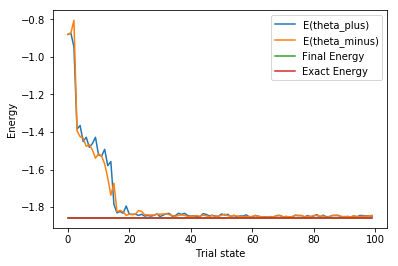

In [3]:
n=2
m=2
device='local_qasm_simulator'

initial_theta=np.zeros(2*n*m)
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1
max_trials=100
ham_name='H2/H2Equilibrium.txt'

#Exact Energy
pauli_list=Hamiltonian_from_file(ham_name)
H=make_Hamiltonian(pauli_list)
exact=np.amin(la.eig(H)[0]).real
        
    
# Optimization
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])


eval_hamiltonian_partial=partial(eval_hamiltonian,Q_program,n,m,ham_name,device,shots,H)
eval_hamiltonian_partial(initial_theta)

initial_c=0.1
target_update=2*np.pi*0.1
SPSA_params=SPSA_calibration(eval_hamiltonian_partial,initial_theta,initial_c,target_update,25)

output=SPSA_optimization(eval_hamiltonian_partial,initial_theta,SPSA_params,max_trials,1);
plt.plot(output[2],label='E(theta_plus)')
plt.plot(output[3],label='E(theta_minus)')
plt.plot(np.ones(max_trials)*output[0],label='Final Energy')
plt.plot(np.ones(max_trials)*exact,label='Exact Energy')
plt.legend()
plt.xlabel('Trial state')
plt.ylabel('Energy')

## Optimizing the potential energy surface 

In [ ]:
# MOLECULE PARAMETERS

molecule='H2' #name of the molecule: options are H2 or LiH

if molecule=='H2':
    n=2 # qubits
    Z1=1
    Z2=1
    min_distance=.2
    max_distance=4
    number_of_points=39
elif molecule=='LiH':
    n=4 # qubits
    Z1=1
    Z2=3
    min_distance=.5
    max_distance=5
    number_of_points=46
    
    
# OPTIMIZATION PARAMETERS 

run_optimization='Yes' # Choose 'Yes' or 'No'

m=2 # depth (number of layers of sq gates - # entanglers is this number -1)
device='local_qasm_simulator'
initial_theta=np.random.randn(2*n*m)  # initial angles 
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1
max_trials=500

initial_c=0.01
target_update=2*np.pi*0.1





####################     COMPUTING FOR THE POTENTIAL ENERGY SURFACE      ###################

mol_distance=np.zeros(number_of_points)
coulomb_repulsion=np.zeros(number_of_points)
electr_energy=np.zeros(number_of_points)
electr_energy_optimized=np.zeros(number_of_points)

Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])

for i in range(number_of_points):

    
    # %%%%%%%%%%%%% Coulomb Repulsion For Diatomic molecules %%%%%%%%%%%%%%%%%%%%%%
        mol_distance[i]=np.around((min_distance+(max_distance-min_distance)*i/(number_of_points-1)),2)
        
        distance=mol_distance[i]/0.529177
        coulomb_repulsion[i]=Z1*Z2/distance
        
    # exact diagonalization
        ham_text=molecule+'/PESMap'+str(i)+'atdistance'+str(mol_distance[i])+'.txt'
        pauli_list=Hamiltonian_from_file(ham_text)
        H=make_Hamiltonian(pauli_list)
        eigen=la.eig(H)
        electr_energy[i]=np.amin(eigen[0])
        
        
        
    # optimization
    
        if run_optimization=='Yes':
            print('\nOPTIMIZING HAMILTONIAN # '+str(i)+' AT INTERATOMIC DISTANCE '+str(mol_distance[i])+' ANGSTROM\n')
            eval_hamiltonian_partial=partial(eval_hamiltonian,Q_program,n,m,ham_name,device,shots,H)
            SPSA_params=SPSA_calibration(eval_hamiltonian_partial,initial_theta,initial_c,target_update,5)
            electr_energy_optimized[i]=SPSA_optimization(eval_hamiltonian_partial,initial_theta,SPSA_params,max_trials,5)[0]
            


plt.plot(mol_distance,electr_energy+coulomb_repulsion,label='Exact')
plt.plot(mol_distance,electr_energy_optimized+coulomb_repulsion,label='Optimized') 
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
        

/Users/amezzac/anaconda/envs/QISKitenv/lib/python3.6/site-packages/ipykernel_launcher.py:63: ComplexWarning: Casting complex values to real discards the imaginary part



OPTIMIZING HAMILTONIAN # 0 AT INTERATOMIC DISTANCE 0.2 ANGSTROM

calibration step # 0 of 5
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
calibrated SPSA_parameters[0] is 1.09582894144
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 0
-0.657129868104
objective function at theta- for step # 0
-0.629599461801
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 75
-2.48531571981
objective function at theta- for step # 75
-2.4853166916
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 80
-2.48523354995
objective function at theta- for step # 80
-2.48549451546
running on backend: local_qasm_simulator
running on backend: local_qasm_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 155
-2.4860165635
objective function at theta- for step # 155
-2.48585348062
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 160
-2.48578693987
obje

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 230
-2.48629401973
objective function at theta- for step # 230
-2.48631959122
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 235
-2.48613959801
objective function at theta- for step # 235
-2.48625345
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qas

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 310
-2.4865536297
objective function at theta- for step # 310
-2.48654715927
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 315
-2.48662076505
objective function at theta- for step # 315
-2.48650179447
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 390
-2.48672849133
objective function at theta- for step # 390
-2.48672843204
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 395
-2.48659988209
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 465
-2.48687133396
objective function at theta- for step # 465
-2.48687698796
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 470
-2.4869306505
objective function at theta- for step # 470
-2.48682802894
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 40
-2.32946872003
objective function at theta- for step # 40
-2.32916098802
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 45
-2.33818385785
objective function at theta- for step # 45
-2.3

running on backend: local_qasm_simulator
objective function at theta+ for step # 115
-2.35888360446
objective function at theta- for step # 115
-2.35912494852
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 120
-2.35928637906
objective function at theta- for step # 120
-2.35912590995
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 195
-2.35948970834
objective function at theta- for step # 195
-2.35949455
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 200
-2.35955008636
objective function at theta- for step # 200
-2.35967243609
running on backend: local_qasm_simulator
running on backend: local_qas

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 275
-2.35960549062
objective function at theta- for step # 275
-2.35975725569
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 280
-2.35990888878
objective function at theta- for step # 280


running on backend: local_qasm_simulator
objective function at theta+ for step # 350
-2.36000100259
objective function at theta- for step # 350
-2.36000426636
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 355
-2.3599366267
objective function at theta- for step # 355
-2.36009273667
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 430
-2.36016237932
objective function at theta- for step # 430
-2.3601463124
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 435
-2.36019220651
objective function at theta- for step # 435
-2.3600050315
running on backend: local_qasm_simulator
running on backend: local_qa

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 0
-0.882967493399
objective function at theta- for step # 0
-0.87629375986
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 5
-1.55647118533
objective function at theta- for step # 5
-1.54990507588
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_si

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 80
-2.22737244921
objective function at theta- for step # 80
-2.22739408978
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 85
-2.22733424455
objective function at theta- for step # 85
-2.22718179476
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 160
-2.22758460942
objective function at theta- for step # 160
-2.22750306384
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 165
-2.22752897656
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 235
-2.22765242205
objective function at theta- for step # 235
-2.22763937666
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 240
-2.22759871249
objective function at theta- for step # 240
-2.22770093986
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 315
-2.22766395185
objective function at theta- for step # 315
-2.22770173212
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 320
-2.22767980654
objective function at theta- for step # 320
-2.2277106492
running on backend: local_q

running on backend: local_qasm_simulator
objective function at theta+ for step # 390
-2.22788937055
objective function at theta- for step # 390
-2.22789975391
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 395
-2.22791127165
objective function at theta- for step # 395
-2.22790766884
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 470
-2.22794884391
objective function at theta- for step # 470
-2.22795605806
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 475
-2.2280417053
objective function at theta- for step # 475
-2.22804117528
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
objective function at theta+ for step # 40
-2.09095963929
objective function at theta- for step # 40
-2.09096863806
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 45
-2.09752362781
objective function at theta- for step # 45
-2.10195998563
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 120
-2.11336416029
objective function at theta- for step # 120
-2.11341556941
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 125
-2.11337346363
objective function at theta- for step # 125
-2.11339936081
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 200
-2.11335191197
objective function at theta- for step # 200
-2.11333844008
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 205
-2.11335861018
objective function at theta- for step # 205


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 275
-2.11344766707
objective function at theta- for step # 275
-2.11342155903
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 280
-2.11338973756
objective function at theta- for step # 280
-2.11336610085
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

In [15]:
electr_energy_optimized

array([-2.48792379, -2.36539438, -2.23670146, -2.10938565, -1.99688218,
       -1.89208317, -1.79556177, -1.70602246, -1.5038631 , -1.56026301,
       -1.49758195, -1.44214839, -1.3934518 , -1.35089926, -1.29335265,
       -1.2808792 , -1.2523154 , -1.23053839, -1.21033021, -1.19237914,
       -1.17762976, -0.79427722, -1.13132976, -1.14690117, -1.13666028,
       -1.1283386 , -1.12211926, -1.0520564 , -0.91966306, -1.05795682,
       -1.01962667, -0.89029563, -0.70154939, -1.0474631 , -0.92398879,
       -1.03054197, -0.58264182, -0.58906631, -0.54816179])